In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [240]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [241]:
app_train = pd.read_csv("application_train.csv")
app_test = pd.read_csv("application_test.csv")
submission = pd.read_csv("sample_submission.csv")

In [242]:
app_train.shape

(307511, 122)

### **Проведем преобразование данных для обучения**

In [274]:
test_id = app_test['SK_ID_CURR']
y_train=app_train['TARGET']

In [244]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [245]:
missing_values = missing_data(app_train)
missing_values.head(20)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


In [246]:
# закодируем категориальные признаки
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [247]:
#выровняем количество столбцов в train и test
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels

In [248]:
#уберем выбросы в столбце DAYS_EMPLOYED для train и test
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

In [249]:
# Уберем целевую переменную из train
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()

In [250]:
features = list(train.columns)
test = app_test.copy()

In [251]:
# Заполним пропущенные значения медианами и нормируем значения признаков
imputer = SimpleImputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))

imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(app_test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [252]:
ext_data = app_train[['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE']]
ext_data_test=app_test[['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE']]

In [253]:
imp = SimpleImputer(strategy = 'median')
sc = MinMaxScaler(feature_range = (0, 1))
imp.fit(ext_data)
sc.fit(ext_data)
ext_data = imp.transform(ext_data)
ext_data_test=imp.transform(ext_data_test)
ext_data = sc.transform(ext_data)
ext_data_test=sc.transform(ext_data_test)

In [271]:
ext_data4 = app_train[['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_EMPLOYED']]
ext_data_test4=app_test[['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_EMPLOYED']]

In [272]:
im = SimpleImputer(strategy = 'median')
scl = MinMaxScaler(feature_range = (0, 1))
im.fit(ext_data4)
scl.fit(ext_data4)
ext_data4 = im.transform(ext_data4)
ext_data_test4=im.transform(ext_data_test4)
ext_data4 = scl.transform(ext_data4)
ext_data_test4=scl.transform(ext_data_test4)

In [273]:
X_train, X_test, y_train, y_test = train_test_split(train, y_train, test_size = 0.3, random_state = 200)

## **Решающие деревья**

### **max_depth**


In [199]:
roc_scores_for_m_ds=[]
m_ds=[5, 6, 7, 8, 10, 12]
for m_d in m_ds:
    tree_model=DecisionTreeClassifier( max_depth=m_d,random_state=10)
    tree_model.fit(X_train, y_train)
    pred_m = tree_model.predict_proba(X_test)[:,1]
    roc_scores_for_m_ds.append(roc_auc_score(y_test, pred_m))
    print("ROC Score:",  roc_auc_score(y_test, pred_m), "for max_depth:", m_d)

ROC Score: 0.7049793956728694 for max_depth: 5
ROC Score: 0.7121680574139312 for max_depth: 6
ROC Score: 0.7139607717699322 for max_depth: 7
ROC Score: 0.7149243898766819 for max_depth: 8
ROC Score: 0.7098484536789998 for max_depth: 10
ROC Score: 0.6928127345026097 for max_depth: 12


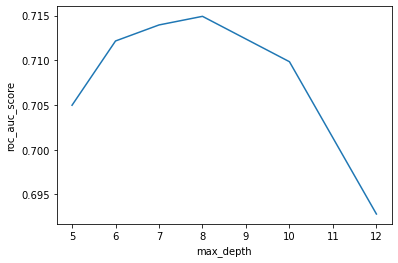

In [200]:
plt.xlabel('max_depth')
plt.ylabel('roc_auc_score')
plt.plot(m_ds, roc_scores_for_m_ds);

Лучший результат достигается при max_depth = 8

### **min_samples_leaf**

In [201]:
roc_scores_for_msls=[]
msls=[20, 50, 100, 150, 200, 250]
for msl in msls:
    tree_model=DecisionTreeClassifier(min_samples_leaf = msl,random_state=10)
    tree_model.fit(X_train, y_train)
    pred_m = tree_model.predict_proba(X_test)[:,1]
    roc_scores_for_msls.append(roc_auc_score(y_test, pred_m))
    print("ROC Score:",  roc_auc_score(y_test, pred_m), "for min_samples_leaf:", msl)

ROC Score: 0.6169980687490334 for min_samples_leaf: 20
ROC Score: 0.6543117146803276 for min_samples_leaf: 50
ROC Score: 0.6815503597661631 for min_samples_leaf: 100
ROC Score: 0.6922189780922563 for min_samples_leaf: 150
ROC Score: 0.7020224526433703 for min_samples_leaf: 200
ROC Score: 0.7074309952704172 for min_samples_leaf: 250


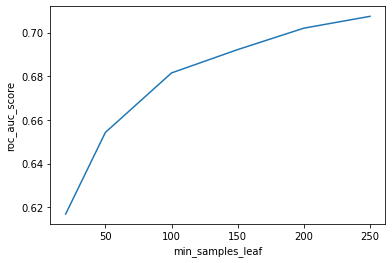

In [202]:
plt.xlabel('min_samples_leaf')
plt.ylabel('roc_auc_score')
plt.plot(msls, roc_scores_for_msls);

В данном случае, с ростом значения параметра min_samples_leaf, результат улучшается

### **min_samples_split**

In [203]:
roc_scores_for_m_ss=[]
m_ss=[10, 20, 30, 50, 100, 150]
for m_s in m_ss:
    tree_model=DecisionTreeClassifier(min_samples_split=m_s, random_state=10)
    tree_model.fit(X_train, y_train)
    pred_m = tree_model.predict_proba(X_test)[:,1]
    roc_scores_for_m_ss.append(roc_auc_score(y_test, pred_m))
    print("ROC Score:",  roc_auc_score(y_test, pred_m), "for min_samples_split:", m_s)

ROC Score: 0.5509486126709591 for min_samples_split: 10
ROC Score: 0.5647088569162244 for min_samples_split: 20
ROC Score: 0.5736571393228249 for min_samples_split: 30
ROC Score: 0.5853718305436396 for min_samples_split: 50
ROC Score: 0.6127263201229344 for min_samples_split: 100
ROC Score: 0.6340769784910573 for min_samples_split: 150


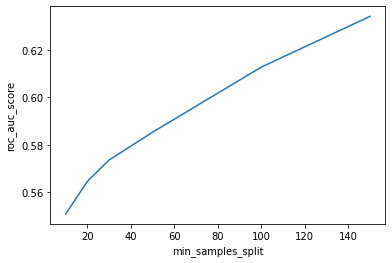

In [204]:
plt.xlabel('min_samples_split')
plt.ylabel('roc_auc_score')
plt.plot(m_ss, roc_scores_for_m_ss);

В данном случае, с ростом значения параметра min_samples_split, результат улучшается

### **GridSearchCV**

In [205]:
tree_model_for_grid=DecisionTreeClassifier(random_state=10)
parameters = {
    'max_depth': [6, 7, 8, 10],
    'min_samples_leaf': [50, 100, 150, 200],
    'min_samples_split': [20, 30, 50, 100]
}
grid_tree = GridSearchCV(estimator=tree_model_for_grid, param_grid=parameters, cv=5)
grid_tree.fit(X_train, y_train)
pred_for_tree= grid_tree.predict_proba(X_test)[:,1]
print("ROC Score:",  roc_auc_score(y_test, pred_for_tree))

ROC Score: 0.7123695260295665


In [206]:
grid_tree.best_params_

{'max_depth': 6, 'min_samples_leaf': 100, 'min_samples_split': 20}

### **RandomizedSearchCV**

In [207]:
random_tree_model = DecisionTreeClassifier(random_state=10)
parameters_for_random_model = {
    'max_depth': [6, 7, 8, 10],
    'min_samples_leaf': [50, 100, 150, 200],
    'min_samples_split': [20, 30, 50, 100]
}
grid_random_tree = RandomizedSearchCV(random_tree_model, parameters_for_random_model, cv=5)
grid_random_tree.fit(X_train, y_train)
random_tree_pred= grid_random_tree.predict_proba(X_test)[:,1]
print("ROC Score:",  roc_auc_score(y_test, random_tree_pred))

ROC Score: 0.7127356350448151


In [208]:
grid_random_tree.best_params_

{'max_depth': 6, 'min_samples_leaf': 150, 'min_samples_split': 100}

## **Случайный лес**

### **n_estimators**

In [209]:
roc_scores_for_trees=[]
trees=[10, 20, 30, 50, 100, 150]
for tree in trees:
    forest_model = RandomForestClassifier(random_state=10, n_estimators=tree)
    forest_model.fit(X_train, y_train)
    pred_forest = forest_model.predict_proba(X_test)[:,1]
    roc_scores_for_trees.append(roc_auc_score(y_test, pred_forest))
    print("ROC Score:",  roc_auc_score(y_test, pred_forest), "for trees:", tree)

ROC Score: 0.6325267004408286 for trees: 10
ROC Score: 0.6590521395545297 for trees: 20
ROC Score: 0.6741606935610257 for trees: 30
ROC Score: 0.6923288178222541 for trees: 50
ROC Score: 0.7087713741970882 for trees: 100
ROC Score: 0.7142530135904381 for trees: 150


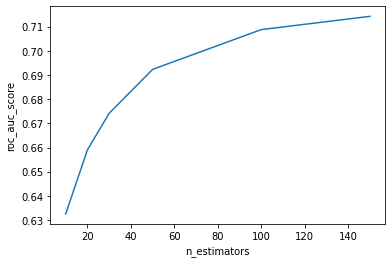

In [210]:
plt.xlabel('n_estimators')
plt.ylabel('roc_auc_score')
plt.plot(trees, roc_scores_for_trees)

В данном случае, с ростом значения параметра n_estimators, результат улучшается

### **max_depth**

In [211]:
roc_scores_for_trees_m_d=[]
m_ds=[5, 6, 7, 8, 10, 12]
for m_d in m_ds:
    forest_model = RandomForestClassifier(random_state=10, max_depth=m_d)
    forest_model.fit(X_train, y_train)
    pred_forest_m_d = forest_model.predict_proba(X_test)[:,1]
    roc_scores_for_trees_m_d.append(roc_auc_score(y_test, pred_forest_m_d ))
    print("ROC Score:",  roc_auc_score(y_test, pred_forest_m_d ), "for max_depth:", m_d)

ROC Score: 0.7231461424775131 for max_depth: 5
ROC Score: 0.7247610331087312 for max_depth: 6
ROC Score: 0.7284451792795108 for max_depth: 7
ROC Score: 0.7291730289176068 for max_depth: 8
ROC Score: 0.7338780685503639 for max_depth: 10
ROC Score: 0.7351494917635935 for max_depth: 12


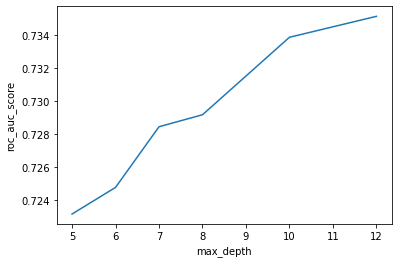

In [212]:
plt.xlabel('max_depth')
plt.ylabel('roc_auc_score')
plt.plot(m_ds, roc_scores_for_trees_m_d)
None

В данном случае, с ростом значения параметра max_depth, результат улучшается




### **min_samples_split**

In [213]:
roc_scores_tree_m_ss=[]
m_ss=[10, 20, 30, 50, 100, 150]
for m_s in m_ss:
    forest_model = RandomForestClassifier(random_state=10, min_samples_split=m_s)
    forest_model.fit(X_train, y_train)
    pred_forest_m_s= forest_model.predict_proba(X_test)[:,1]
    roc_scores_tree_m_ss.append(roc_auc_score(y_test, pred_forest_m_s))
    print("ROC Score:",  roc_auc_score(y_test, pred_forest_m_s), "for min_samples_split:", m_s)

ROC Score: 0.7154551061378608 for min_samples_split: 10
ROC Score: 0.7187943316542209 for min_samples_split: 20
ROC Score: 0.723827090705617 for min_samples_split: 30
ROC Score: 0.7236929682710588 for min_samples_split: 50
ROC Score: 0.7305893526698115 for min_samples_split: 100
ROC Score: 0.73297785765142 for min_samples_split: 150


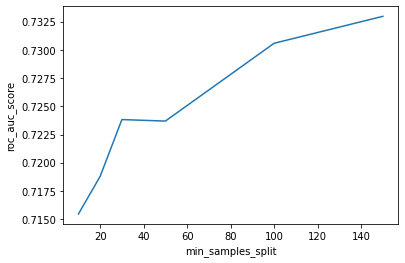

In [214]:
plt.xlabel('min_samples_split')
plt.ylabel('roc_auc_score')
plt.plot(m_ss, roc_scores_tree_m_ss);

В данном случае, с ростом значения параметра min_samples_split, результат улучшается

### **GridSearchCV**

In [215]:
forest_model = RandomForestClassifier(random_state=10)
parameters = {
    'n_estimators':[20, 30, 50, 100],
    'max_depth': [6, 7, 8, 10],
    'min_samples_split': [20, 30, 50, 100]
}
grid_forest = GridSearchCV(estimator=forest_model, param_grid=parameters, cv=5)
grid_forest.fit(X_train, y_train)
pred_for_forest= grid_forest.predict_proba(X_test)[:,1]
print("ROC Score:",  roc_auc_score(y_test, pred_for_forest))

ROC Score: 0.7209278698166903


In [216]:
grid_forest.best_params_

{'max_depth': 6, 'min_samples_split': 20, 'n_estimators': 20}

### **RandomizedSearchCV**

In [217]:
forest_model = RandomForestClassifier(random_state=10)
parameters_for_random_forest= {
    'n_estimators':[20, 30, 50, 100],
    'max_depth': [6, 7, 8, 10],
    'min_samples_split': [20, 30, 50, 100]
}
grid_random_forest =RandomizedSearchCV(forest_model, parameters_for_random_forest, cv=5)
grid_random_forest.fit(X_train, y_train)
pred_for_random_forest= grid_random_forest.predict_proba(X_test)[:,1]
print("ROC Score:",  roc_auc_score(y_test, pred_for_random_forest))

ROC Score: 0.7303981869558056


In [218]:
grid_random_forest.best_params_

{'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 50}

## **Оценка важности признаков**

In [259]:
#В качестве значений гиперпараметров, выберем значения RandomizedSearchCV, т.к.
#они дают лучший скор
final_forest = RandomForestClassifier(random_state=10, max_depth=8, min_samples_split=20, n_estimators=30)
final_forest.fit(X_train, y_train)
pred_final_forest= final_forest.predict_proba(X_test)[:,1]

In [278]:
print("ROC Score:",  roc_auc_score(y_test, pred_final_forest))

ROC Score: 0.7249512578896431


In [263]:
feature_scores=pd.Series(final_forest.feature_importances_, index=features).sort_values(ascending=False)

In [264]:
feature_scores.head(15)

EXT_SOURCE_3                                         0.190290
EXT_SOURCE_2                                         0.165107
EXT_SOURCE_1                                         0.069743
DAYS_EMPLOYED                                        0.067092
DAYS_LAST_PHONE_CHANGE                               0.029130
DAYS_BIRTH                                           0.025419
NAME_EDUCATION_TYPE_Higher education                 0.023104
REGION_RATING_CLIENT_W_CITY                          0.019872
AMT_GOODS_PRICE                                      0.016516
CODE_GENDER_F                                        0.015945
NAME_INCOME_TYPE_Working                             0.014243
DAYS_ID_PUBLISH                                      0.013159
AMT_CREDIT                                           0.011752
REGION_POPULATION_RELATIVE                           0.011283
NAME_EDUCATION_TYPE_Secondary / secondary special    0.011213
dtype: float64

Таким образом, больше всего на результат влияют признаки EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1, DAYS_EMPLOYED, DAYS_LAST_PHONE_CHANGE

In [265]:
#построим дерево для 5 важных признаков
final_forest_imp_features = RandomForestClassifier(random_state=10, max_depth=8, min_samples_split=20, n_estimators=30)
final_forest_imp_features.fit(ext_data, y_train)
pred_final_forest_imp_features= final_forest_imp_features.predict_proba(ext_data_test)[:,1]

In [266]:
submission['SK_ID_CURR'] = test_id.values
submission['TARGET'] = pred_final_forest_imp_features

In [267]:
submission.to_csv('my_sub5features.csv', index = False)

Использование 5 самых важных признаков дает немного менее точный результат, чем использование всех признаков

In [275]:
#построим дерево для 4 важных признаков, исключим самый важный
final_forest_imp_features4 = RandomForestClassifier(random_state=10, max_depth=8, min_samples_split=20, n_estimators=30)
final_forest_imp_features4.fit(ext_data4, y_train)
pred_final_forest_imp_features4= final_forest_imp_features4.predict_proba(ext_data_test4)[:,1]

In [276]:
submission['SK_ID_CURR'] = test_id.values
submission['TARGET'] = pred_final_forest_imp_features4

In [277]:
submission.to_csv('my_sub4features.csv', index = False)

Скор для 5 важных признаков 0.71642

Скор для 4 важных признаков 0.71556

Таким образом, можно отметить, что неиспользуя самый важный признак EXT_SOURCE_3 мы получаем менее точный результат